In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, \
                            classification_report, recall_score, precision_recall_curve
import seaborn as sns

# X_train
path_X_train = "pickles/X_train.pickle"
with open(path_X_train, 'rb') as data:
    X_train = pickle.load(data)

# y_train
path_y_train = "pickles/y_train.pickle"
with open(path_y_train, 'rb') as data:
    y_train = pickle.load(data)

# X_test
path_X_test = "pickles/X_test.pickle"
with open(path_X_test, 'rb') as data:
    X_test = pickle.load(data)

# y_test
path_y_test = "pickles/y_test.pickle"
with open(path_y_test, 'rb') as data:
    y_test = pickle.load(data)

In [11]:
# Taken from Sabber Ahamed's https://github.com/msahamed/handle_imabalnce_class
class Ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)
        num_classes = len(np.unique(y))

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, 
                                     random_state = 0).split(X, y))

        train_probs = np.zeros((X.shape[0], num_classes))
        test_probs = np.zeros((T.shape[0], num_classes))
        
        train_pred = np.zeros((X.shape[0], len(self.base_models)))
        test_pred = np.zeros((T.shape[0], len(self.base_models)* self.n_splits))
        f1_scores = np.zeros((len(self.base_models), self.n_splits))
        recall_scores = np.zeros((len(self.base_models), self.n_splits))
        
        test_col = 0
        for i, clf in enumerate(self.base_models):
            
            for j, (train_idx, valid_idx) in enumerate(folds):
                
                X_train = X[train_idx]
                Y_train = y[train_idx]
                X_valid = X[valid_idx]
                Y_valid = y[valid_idx]
                
                clf.fit(X_train, Y_train)
                
                valid_pred = clf.predict(X_valid)
                recall  = recall_score(Y_valid, valid_pred, average='binary')
                f1 = f1_score(Y_valid, valid_pred, average='binary')
                
                recall_scores[i][j] = recall
                f1_scores[i][j] = f1
                
                train_pred[valid_idx, i] = valid_pred
                test_pred[:, test_col] = clf.predict(T)
                test_col += 1
                
                # Probabilities
                valid_probs = clf.predict_proba(X_valid)
                train_probs[valid_idx, :] = valid_probs
                test_probs += clf.predict_proba(T)
                
                print( "Model - {} and CV - {} recall: {}, f1_score: {}".format(i, j, recall, f1))
                
            test_probs /= self.n_splits
            
        return train_probs, test_probs, train_pred, test_pred

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
# class_weight = dict({0:1, 1:10})

rf = RandomForestClassifier(bootstrap=True, class_weight='balanced', criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False,
            random_state=0,
            verbose=0, warm_start=False)

lr = LogisticRegression(class_weight='balanced', max_iter=1000)

In [13]:
base_models = [rf]
n_splits = 5
lgb_stack = Ensemble(n_splits = n_splits, base_models = base_models)        

In [14]:
train_probs, test_probs, train_pred, test_pred = lgb_stack.predict(X_train, y_train, X_test)

Model - 0 and CV - 0 recall: 0.4913657770800628, f1_score: 0.35062661905762094
Model - 0 and CV - 1 recall: 0.4930351186972729, f1_score: 0.36246934948795617
Model - 0 and CV - 2 recall: 0.4619309262166405, f1_score: 0.34742823407866574
Model - 0 and CV - 3 recall: 0.4835164835164835, f1_score: 0.3577235772357724
Model - 0 and CV - 4 recall: 0.4662480376766091, f1_score: 0.3538083538083538


1. The F-1 score of the model 0.3544197251367786

2. The recall score of the model 0.479219810839449

3. Classification report 
               precision    recall  f1-score   support

           0       0.92      0.82      0.87    174951
           1       0.28      0.48      0.35     25481

    accuracy                           0.78    200432
   macro avg       0.60      0.65      0.61    200432
weighted avg       0.83      0.78      0.80    200432
 



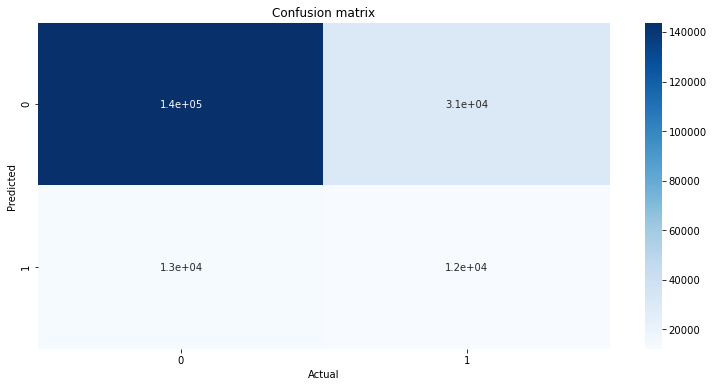

In [15]:
print('1. The F-1 score of the model {}\n'.format(f1_score(y_train, train_pred, average='binary')))
print('2. The recall score of the model {}\n'.format(recall_score(y_train, train_pred, average='binary')))
print('3. Classification report \n {} \n'.format(classification_report(y_train, train_pred)))
conf_matrix = confusion_matrix(y_train, train_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

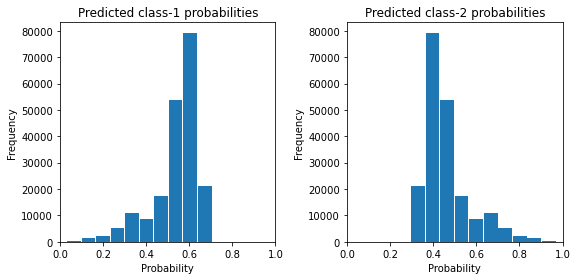

In [17]:
plt.figure(figsize=(12, 4))
num_classes = 2
for i in range(num_classes):
    plt.subplot(1, 3, i+1)
    plt.hist(train_probs[:, i], bins=10, histtype='bar', rwidth=0.95)
    plt.xlim(0,1)
    plt.title('Predicted class-{} probabilities'.format(i+1))
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import functools

cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 0)

rf = RandomForestClassifier(random_state = 0) 
scoring = {'Recall': make_scorer(functools.partial(recall_score, average='binary')),
           'f1_score': make_scorer(functools.partial(f1_score, average='binary'))
          }

params = {'max_depth': [6, 8, 10, 20], 
          'min_samples_split': [5, 10, 15],
          'min_samples_leaf' : [4, 8, 12],
          'n_estimators' : [300, 400, 500],
          'class_weight': ['balanced']
         }

grid_clf = GridSearchCV(estimator = rf, param_grid = params, cv = cv, verbose=1)
grid_clf.fit(X_train, y_train)